<div style="background-color:#0A497B ;padding:10px">
    <h2 style="color:white;text-align:center;"> <center> E-Challenge Machine Learning Edition 2021 
    </h2>
</div>


<h2> A predictive maintenance worflow by 
    
    
    
<h2> ACS Machine Learning
    
    
    
    
<ul>
    <li>Arias Santiago</li>
    <li>Carrillo Carlos</li>
    <li>Salazar Bryan</li>
</ul>

# 1 Preprocesamiento

## 1.1 Importar las librerías para el proyecto 

In [ ]:
# Algunos tips para este script fueron tomados de lo enviado por SPE Ecuador Section 
# Está ubicado en el siguiente enlace
# https://gitlab.com/spe.ec/e-challenge-prediction-models-for-historical-data-of-esp-patterns

import numpy as np                                 # Libreria para arreglos de datos
import pandas as pd                                # Libreria para generar DataFrames y leer archivos csv
import matplotlib.pyplot as plt                    # Libreria visualizar gráficos
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker 

plt.rcParams['agg.path.chunksize'] = 10000         # Comando para permitir miles de datos en los gráficos
#%matplotlib inline                                 # %matplotlib inline Comando que hará que los gráficos aparezcan en Jupyter Notebook
import seaborn as sns                              # Libreria visualizar gráficos dinamicos y analisis
import plotly.express as px                        # Libreria visualizar gráficos dinamicos y avanzados
import random                                      # Libreria que perite escoger datos al azar
import datetime as dt                              # Libreria para trabajar con datos de tipo fecha
import os                                          # Libreria para trabajar con carpetas del sistema 
import glob                                        # Recuperar archivos/nombres de ruta que coinciden con un patrón especificado
import zipfile                                     # Libreria para comprimir archivos

from IPython.display import clear_output           # Borrar la salida de una celda o muchos resultados de iteraciones
from tqdm import tqdm                              # Barra de progreso

import warnings                                    # Libreria para control de advertencias
warnings.filterwarnings('ignore')                  # Comando para ignorar advertencias
clear_output()                                     # limpiar la salida de esta celda

## 1.2 Cargar Data

In [ ]:
# Ubicación de la ruta hacia la carpeta que contiene la informacion
PATH_01 = 'Train'
PATH_02 = 'Test'

In [ ]:
# Get paths of every single .csv file
train_dirs = glob.glob(PATH_01+ '/*.csv')
train_dirs.sort()
test_dirs = glob.glob(PATH_02+ '/*.csv')
test_dirs.sort()

## 1.3 Estructurando la data 

 Concat High Frequency Files

In [ ]:
# Función para leer archivos csv y convertirlo a DataFrame y combinar todos estos Dataframe
def concat_data(files):
    
    dataframes = []
    for i in range(len(files)):
        locals()['df'+f'{i}'] = pd.read_csv(files[i],parse_dates=[1])
        dataframes.append(locals()['df'+f'{i}'])
    return pd.concat(dataframes,axis=0).reset_index().drop('index',axis=1)

In [ ]:
# Concat High Frequency Data
train = concat_data(train_dirs[:-1])
train = train.sort_values(by=['DATE']).reset_index().drop('index',1)

test = concat_data(test_dirs[:-1])
test = test.sort_values(by=['DATE']).reset_index().drop('index',1)

In [ ]:
# Read Production Data
production_train = pd.read_csv(train_dirs[-1],parse_dates=[1])
production_train = production_train.sort_values(by=['DATE']).reset_index().drop('index',1)

production_test = pd.read_csv(test_dirs[-1],parse_dates=[1])
production_test = production_test.sort_values(by=['DATE']).reset_index().drop('index',1)

PRESS_INT & PRESS_INTK refer to the same thing (Intake Pressure), however the second is used only for the values of 2019.
TEMP_INT & TEMP_INTK refer to the same thing (Intake Temperature), however the second is used only for the values of 2019.

In [ ]:
# Therefore, we can run the next instruction to merge both columns

train['PRESS_INT'] = train['PRESS_INT'].fillna(train['PRESS_INTK'])
train['TEMP_INT'] = train['TEMP_INT'].fillna(train['TEMP_INTK'])
test['PRESS_INT'] = test['PRESS_INT'].fillna(test['PRESS_INTK'])
test['TEMP_INT'] = test['TEMP_INT'].fillna(test['TEMP_INTK'])

del train['PRESS_INTK']
del train['TEMP_INTK']
del test['PRESS_INTK']
del test['TEMP_INTK']

In [ ]:
train_wells = train['WELL_ID'].unique()
test_wells = test['WELL_ID'].unique()

print('Train wells: ',len(train_wells))
print('Test wells: ',len(test_wells))

Train wells:  100
Test wells:  15


## 1.4 Merge High Frequency & Production Data

In [ ]:
# Define a function to merge High_Frequency Data with Production Data
# This function takes 1.84 hours to run

def structurer(wells,production_data,high_freq_data):

  df = []

  for well in wells:                                                            # Loop over well list (train/test)

    pump = production_data[production_data['WELL_ID'] == well]                  # Select production data for the looped-in well
    pump = pump[pump['DATE'].dt.year>=2019].sort_values(by=['DATE'])            # Select data from 2019 onwards 
    duplicated = pump[pump['DATE'].duplicated(keep=False)]                      # Find Duplicated Values
    idx_2ptd = duplicated[duplicated['PIP(PSI)'].isnull()].index                # Get index of Duplicated Values
    pump = pump.drop(index=idx_2ptd).reset_index().drop('index',1)              # Drop Duplicated Rows with missing Values

    pump = pump.set_index('DATE').asfreq('d',method='pad')                      # Set frequency of dates by one day & Fill missing values 
    pump = pump.fillna(method='ffill') 
    pump = pump.reset_index()

    sensor = high_freq_data[high_freq_data['WELL_ID'] == well]                  # Select high frequency data for the looped-in well
    sensor = sensor.drop_duplicates().reset_index().drop('index',1)             # Drop Duplicated Values

    sensor_dates = sensor['DATE'].unique()                                      # Get High Frequency Dates
    pump_dates = pump['DATE'].unique()                                          # Get Production Dates

    merged = []

    try:

      for _ in pump_dates:                                                      # Loop over production dates

        if _ in sensor_dates:                                                   # If production date in sensor dates
          time = pd.Timestamp(_)                                                  
          shot = sensor[sensor['DATE'].dt.date == (dt.date(time.year, time.month, time.day))].reset_index().drop('index',1) # Select all rows from sensor data equal to the "looped-in" production date
          bullet = pump[pump['DATE'].dt.date == time].reset_index().drop('index',1) # Select production information regarding looping date 

          for i in bullet.keys().drop(['WELL_ID','DATE']):
            shot[i] = bullet.loc[0,i]                                           # Append Production columns to sensor data 
          merged.append(shot)                                                   # Append merged data to a list

        else:                                                                   # If production date not in sensor dates
          
          time = pd.Timestamp(_)

          year, month = time.year, time.month                                   # Gete year and month
          sun = sensor[sensor['DATE'].dt.year == year]                          # Select sensor data from that year
          moon = sun[sun['DATE'].dt.month == month].reset_index().drop('index',1) # Select sensor data from that month
          bullet = pump[pump['DATE'].dt.date == time].reset_index().drop('index',1) # Select production information regarding looping date  

          if len(moon) != 0:
            closest = min(list(moon['DATE'].dt.date), key = lambda sub: abs(np.datetime64(sub) - np.datetime64(time))) # Get the closest date from sensor data to looping production date
            
            if abs(np.datetime64(closest) - np.datetime64(time)).astype('timedelta64[D]') <= dt.timedelta(days=1): # If closest date and looping date differ by up to 1 day       
              for i in bullet.keys().drop(['WELL_ID','DATE']):
                moon = moon[moon['DATE'].dt.date == dt.date(closest.year, closest.month, closest.day)] # Select all the the rows from sensor data related to closest date
                moon[i] = bullet.loc[0,i]                                       # Append Production columns to sensor data 
              merged.append(moon)                                               # Append merged data to a list

      merged = pd.concat(merged,0).reset_index().drop('index',1)                # Once all the production dates are looped, concat the list with merged data
      merged = merged.drop_duplicates(subset='DATE',keep='last')                # Drop duplicated values
      df.append(merged)                                                         # Append Merged data of looped-in well to a list

    except:
      print(well)
                                                          
  return pd.concat(df,axis=0).reset_index().drop('index',1)

In [ ]:
# Descomentar para ejecutar la función, esto demora alrededor de 1hr 40 min
#"""
#  Structure Train & Test Data
#"""
#structured_train = structurer(train_wells,production_train,train)
#structured_test = structurer(test_wells,production_test,test)

In [ ]:
# Look for wells without outputs
#pd.set_option('max_rows',105)
#structured_data.groupby(by=['WELL_ID'])['WellFailure'].unique()

In [ ]:
#to_remove = ['DEEPWATER-55X0XE', 'DEEPWATER-D4EH50', 'DEEPWATER-ZISKRZ']
#idxs = []

#for i in to_remove:
#  idx = structured_train[structured_train['WELL_ID']==i].index
#  idxs.append(idx)
#
#structured_train = structured_train.drop(np.hstack(idxs))

## 1.5 Cargar data estructurada

<b>To evaluate this notebook, we import the structured version of Training and Blind Data

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dQtNn0W6W9zsZtzPosSmGdei5IC09Kag' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dQtNn0W6W9zsZtzPosSmGdei5IC09Kag" -O structured_blind.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Lb33ELvRVt6WOT2lKOYWDMzPOo9K4mz8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Lb33ELvRVt6WOT2lKOYWDMzPOo9K4mz8" -O structured_train.csv && rm -rf /tmp/cookies.txt

In [ ]:
train = pd.read_csv('structured_train.csv',parse_dates=[1])
test = pd.read_csv('structured_blind.csv',parse_dates=[1])

In [ ]:
# %%time
# # Nosotros guardamos la data estructurada en un csv y la procedemos a cargar. 
# train = pd.read_csv('estructurada_train.csv', index_col = 0)
# test = pd.read_csv('estructurada_test.csv', index_col = 0)

Wall time: 1min 2s


## 1.6 Tratamientos de variables

In [ ]:
train.describe().round(2)

CURRENT  PRESS_DESC   FREQUENCY  ...  PROF_INTAKE    AMPERAGE     PSI_CAB
count  7746508.00  7699161.00  7947463.00  ...   8235288.00  8235288.00  8235288.00
mean        37.03     3604.62       58.12  ...      9636.45       40.09      122.69
std         28.38     2084.58       26.31  ...       495.03       20.27       78.21
min          0.00    -3276.00        0.00  ...       997.00       10.00        0.50
25%         23.00     3656.00       54.00  ...      9452.00       24.70       60.00
50%         33.00     3951.00       56.00  ...      9614.00       34.00      100.00
75%         55.00     4126.00       60.00  ...      9899.00       57.00      161.44
max      51970.00    94906.90     5051.00  ...     11850.00      408.00     8000.00

[8 rows x 21 columns]

In [ ]:
test.describe().round(2)

CURRENT  PRESS_DESC  FREQUENCY  ...  PROF_INTAKE   AMPERAGE    PSI_CAB
count  740408.00   755074.00  750060.00  ...    786091.00  786091.00  786091.00
mean       34.30     2985.21      45.44  ...      9418.03      43.12      81.11
std        25.53     1439.78      23.81  ...       466.33      19.07      56.63
min         0.00        0.00       0.00  ...      8804.00      12.00       0.00
25%        14.00     2904.00      44.00  ...      8994.00      24.00      50.00
50%        31.00     3579.00      53.00  ...      9226.00      46.00      80.00
75%        63.50     3873.40      61.00  ...      9490.00      63.00     100.00
max       204.30    14590.80     140.00  ...     10630.00      75.00     936.00

[8 rows x 21 columns]

In [ ]:
print(train.shape)
print(test.shape)

(8235288, 25)
(786091, 25)


In [ ]:
# Debido a que tiene valores atípicos el GOR y GLR se procede a realizar calculos con las variables
# El modelo entenderá mejor valores de GOR Y GLR, que combinan las tasas de fluido.
# Se procede a no tomar en cuenta BFPD, BOPD, BWPD, MSCF
train['GOR(MSFC/BPPD)']=train['MSCF']/train['BOPD']*1000
train['GLR(SCF/BFPD)']=train['MSCF']/train['BFPD']*1000
test['GOR(MSFC/BPPD)']=test['MSCF']/test['BOPD']*1000
test['GLR(SCF/BFPD)']=test['MSCF']/test['BFPD']*1000

# Al unir data alta frecuencia con histórico de producción, se observa que las siguientes 
# variables son de similares características:
#- PIP (PSI) con PRESS_INT
#- AMPERAGE con CURRENT
#- FREQUENCY con FREC(Hz)

In [ ]:
# Relleno de variables similares, tomando en cuenta las variables PRESS_INT, CURRENT, FREQUENCY 
# Se procede a rellenar los valores faltantes ejecutando lo siguiente.

train['PRESS_INT'] = train['PRESS_INT'].fillna(train['PIP(PSI)'])
train['CURRENT'] = train['CURRENT'].fillna(train['AMPERAGE'])
train['FREQUENCY'] = train['FREQUENCY'].fillna(train['FREC(Hz)'])
test['PRESS_INT'] = test['PRESS_INT'].fillna(test['PIP(PSI)'])
test['CURRENT'] = test['CURRENT'].fillna(test['AMPERAGE'])
test['FREQUENCY'] = test['FREQUENCY'].fillna(test['FREC(Hz)'])

In [ ]:
# Se extrae y ordena las variables de interés luego de hacer el análisis
extract_columns = ['WELL_ID','DATE','CURRENT','FREQUENCY','PRESS_DESC','PRESS_INT','TEMP_INT',
                  'TEMP_MOT','OUT_VOLT','VIBRATION','GOR(MSFC/BPPD)','GLR(SCF/BFPD)','BSW',
                   'API','PROF_INTAKE','PUMP', 'PSI_CAB','WellFailure']

In [ ]:
train = train[extract_columns]
test = test[extract_columns]

## 1.7 Gráfico de valores perdidos

In [ ]:
def missings(df):
  data = df.drop(['WELL_ID'],axis=1)
  data_count = data.count()
  fig, ax = plt.subplots(1, 1, figsize=(15, 7))
  ax = sns.barplot(x= data_count.index, y = data_count, palette='crest')
  ax.set_xticklabels(data_count.index, rotation=70) 
  ax.set_yticks([])

In [ ]:
missings(train)

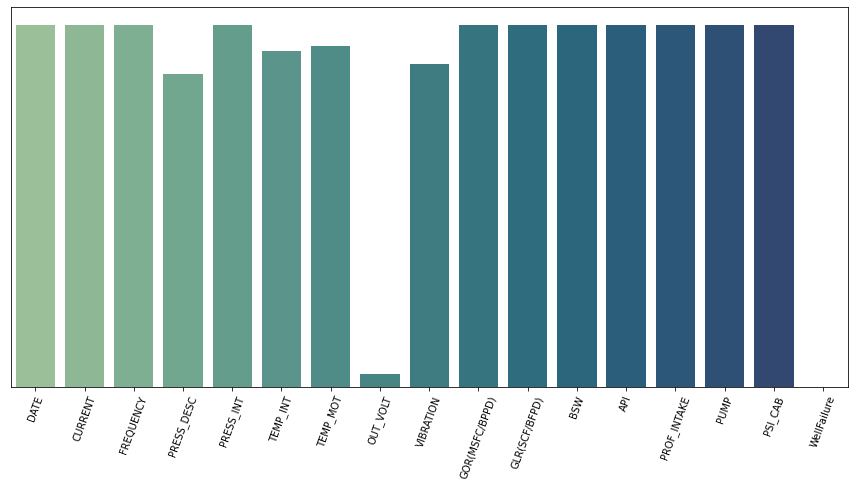

In [ ]:
missings(test)

In [ ]:
# Debido a valores faltantes en cada columna del data frame se procede a usar la siguiente función
# para rellenar con el valor anterior y posterior según corresponda.
def input_nans(df): 
    df = df.drop(['OUT_VOLT'],axis=1)# Debido a que tiene demasiado nan se procede a eliminar esta variable
    for i in df.keys().drop('WellFailure'):
        df[[i]] = df[[i]].fillna(method='ffill')
        df[[i]] = df[[i]].fillna(method='bfill')
    return df

In [ ]:
train = input_nans(train)
test = input_nans(test)

In [ ]:
train.isna().sum()

WELL_ID                 0
DATE                    0
CURRENT                 0
FREQUENCY               0
PRESS_DESC              0
PRESS_INT               0
TEMP_INT                0
TEMP_MOT                0
VIBRATION               0
GOR(MSFC/BPPD)          0
GLR(SCF/BFPD)           0
BSW                     0
API                     0
PROF_INTAKE             0
PUMP                    0
PSI_CAB                 0
WellFailure       8235182
dtype: int64

In [ ]:
test.isna().sum()

WELL_ID                0
DATE                   0
CURRENT                0
FREQUENCY              0
PRESS_DESC             0
PRESS_INT              0
TEMP_INT               0
TEMP_MOT               0
VIBRATION              0
GOR(MSFC/BPPD)         0
GLR(SCF/BFPD)          0
BSW                    0
API                    0
PROF_INTAKE            0
PUMP                   0
PSI_CAB                0
WellFailure       786081
dtype: int64

# 2 EDA

## 2.1 Mostrar atípicos con caja y bigotes

In [ ]:
#La siguiente función fue tomada de la exposición de Felix Gallo dada en el Hands On del
# reto E - Challenge ML Tercer Día - Classification Models 

def mostrar_atípicos(df, params): 
  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
  axs = axs.ravel()

  for ax, i in zip(axs, params):
    ax = sns.boxplot(data=df[i],palette="Set3", ax=ax);
    ax.set_xticks([])
    ax.set_xlabel(i)

Wall time: 7.61 s


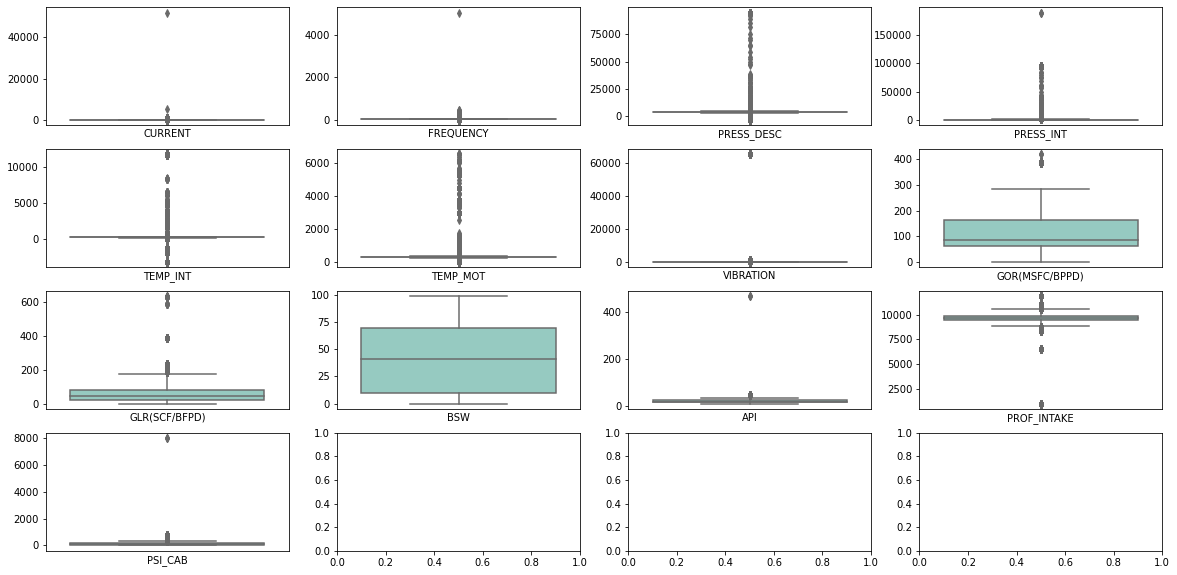

In [ ]:
%%time
mostrar_atípicos(train, train.keys().drop(['DATE','WELL_ID','WellFailure','PUMP']))

In [ ]:
%%time
mostrar_atípicos(test, test.keys().drop(['DATE','WELL_ID','WellFailure','PUMP']))

Wall time: 1.75 s


## 2.2 Limpiar datos atípicos con rangos normales y con desviación estándar

In [ ]:
# Rangos normales dados
# PIP:180 - 2400 (PSI)
# AMP: 20 - 90 (A)
# FREQUENCY: 35 - 75 (Hz)
# INTK TEMP: 175 - 232 (°F)
# ENGINE TEMP: 230 -355 (°F)
# VIBRATION: 0 - 0.8 
train['CURRENT'].values[train['CURRENT']>90] =90
train['CURRENT'].values[train['CURRENT']<0] =0
train['FREQUENCY'].values[train['FREQUENCY']>70] =70
train['FREQUENCY'].values[train['FREQUENCY']<0] =0
train['PRESS_INT'].values[train['PRESS_INT']>2400] =2400
train['PRESS_INT'].values[train['PRESS_INT']<0] =0
train['TEMP_INT'].values[train['TEMP_INT']>232] =232
train['TEMP_INT'].values[train['TEMP_INT']<0] =0
train['TEMP_MOT'].values[train['TEMP_MOT']>355] =355
train['TEMP_MOT'].values[train['TEMP_MOT']<0] =0
train['VIBRATION'].values[train['VIBRATION'] > 10] = 10 #Causa ruido el piezoeléctrico está dañado
train['VIBRATION'].values[train['VIBRATION'] < 0 ] = 0

In [ ]:
test['CURRENT'].values[test['CURRENT']>90] =90
test['CURRENT'].values[test['CURRENT']<0] =0
test['FREQUENCY'].values[test['FREQUENCY']>70] =70
test['FREQUENCY'].values[test['FREQUENCY']<0] =0
test['PRESS_INT'].values[test['PRESS_INT']>2400] =2400
test['PRESS_INT'].values[test['PRESS_INT']<0] =0
test['TEMP_INT'].values[test['TEMP_INT']>232] =232
test['TEMP_INT'].values[test['TEMP_INT']<0] =0
test['TEMP_MOT'].values[test['TEMP_MOT']>355] =355
test['TEMP_MOT'].values[test['TEMP_MOT']<0] =0
test['VIBRATION'].values[test['VIBRATION'] > 10] = 10 #Causa ruido el piezoeléctrico está dañado
test['VIBRATION'].values[test['VIBRATION'] < 0 ] = 0

In [ ]:
#La siguiente función fue tomada de la exposición de Felix Gallo dada en el Hands On del
# reto E - Challenge ML Tercer Día - Classification Models 

def outlier_replacer(df,params,n_std):  
  #The original code of this function was written by Daniel Romero, refer to: https://www.linkedin.com/in/jdromerom/
  remove = df[params]
  for i in remove.keys():

    min,max = remove[i].mean()-(n_std*remove[i].std()),remove[i].mean()+(n_std*remove[i].std())

    min_idx = list(remove.loc[remove[i]<=min].index.values)
    max_idx = list(remove.loc[remove[i]>=max].index.values)

    remove.at[min_idx,i] = min
    remove.at[max_idx,i] = max
    
    df[i] = remove[i]

  return df

In [ ]:
%%time
train = outlier_replacer(train,train.keys().drop(['WELL_ID','DATE','CURRENT','FREQUENCY',
                                                  'PRESS_INT','TEMP_INT','TEMP_MOT','VIBRATION',
                                                  'PUMP','WellFailure']),2.5)

CPU times: user 5.82 s, sys: 623 ms, total: 6.44 s
Wall time: 6.33 s


In [ ]:
%%time
test = outlier_replacer(test,test.keys().drop(['WELL_ID','DATE','CURRENT','FREQUENCY',
                                                  'PRESS_INT','TEMP_INT','TEMP_MOT','VIBRATION',
                                                  'PUMP','WellFailure']),2.5)

CPU times: user 696 ms, sys: 3.62 ms, total: 700 ms
Wall time: 696 ms


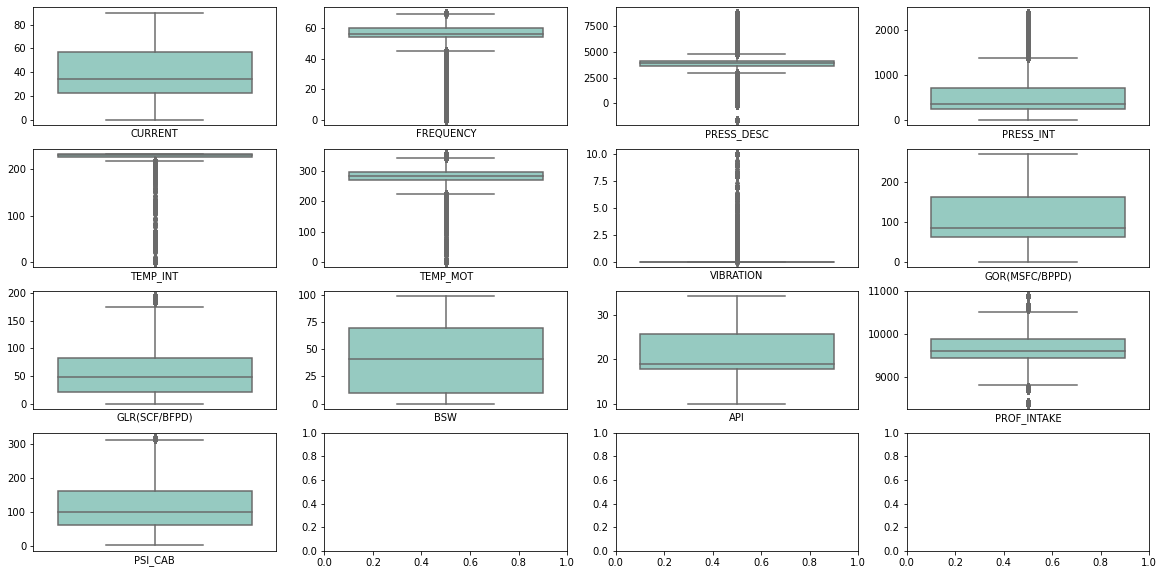

In [ ]:
# Mostrando despues de limpieza
mostrar_atípicos(train, train.keys().drop(['DATE','WELL_ID','WellFailure','PUMP']))

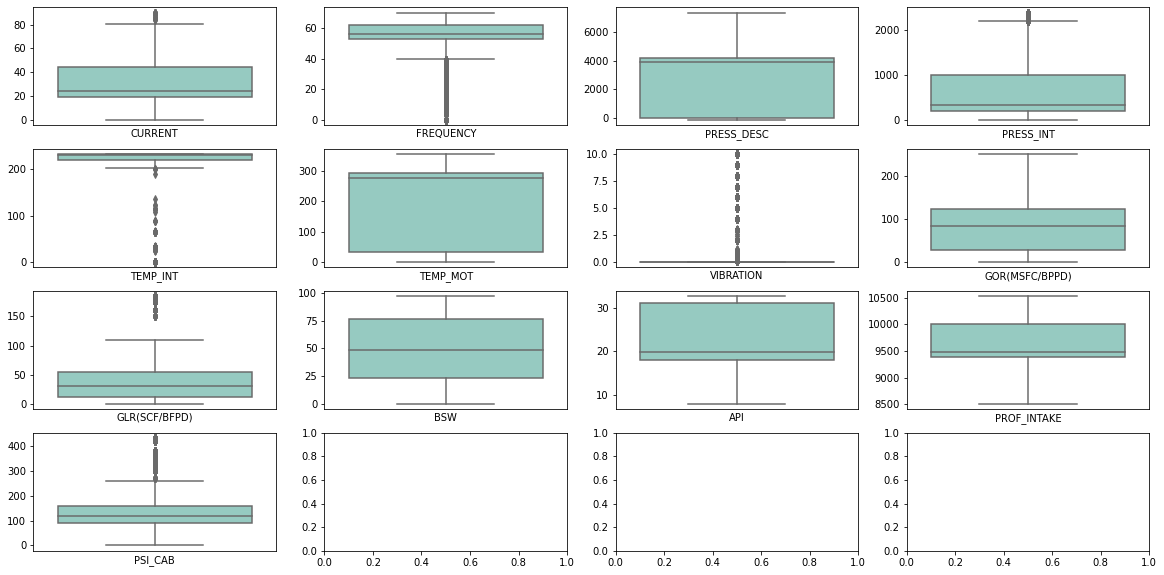

In [ ]:
# Mostrando después de limpieza
mostrar_atípicos(test, test.keys().drop(['DATE','WELL_ID','WellFailure','PUMP']))

## 2.3 Selección de variables correlacionales 

In [ ]:
data_combinada = train[(train["WellFailure"] == 'yes') | (train["WellFailure"] == 'Manual off')]

In [ ]:
data_combinada['WellFailure'].replace(('yes','Manual off'),(0,1),inplace=True)

In [ ]:
#La siguiente función fue tomada de la exposición de Julio Murillo dada en el Hands On del
# reto E - Challenge ML Segundo Día - Regression Models 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
features = data_combinada.drop(columns =['DATE','WELL_ID','WellFailure','PUMP'])
target = data_combinada['WellFailure'].values

In [ ]:
def feature_selection(features, target , model = RandomForestRegressor()):
    model = model
    model.fit(features, target)
    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
    indices = np.argsort(importances)[::-1]
    
    print("Feature Rankin:")
    
    for f in range(features.shape[1]):
        print("%d. feature %d (%f)" % (f+1, indices[f], importances[indices[f]]))
        
    plt.figure()
    plt.title("Variable selection", fontsize = 15)
    plt.bar(range(features.shape[1]), importances[indices], color = "red", align = "center")
    plt.xticks(range(features.shape[1]), indices, fontsize =14)
    plt.yticks(fontsize = 14)
    plt.xlim([-1, features.shape[1]])
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Importances', fontsize = 14)
    plt.savefig('Feature Importance RFR Target_2.png',dpi=600)
    plt.show()

Feature Rankin:
1. feature 10 (0.221155)
2. feature 8 (0.184610)
3. feature 1 (0.130389)
4. feature 0 (0.123256)
5. feature 12 (0.099289)
6. feature 7 (0.092442)
7. feature 5 (0.068245)
8. feature 9 (0.060547)
9. feature 4 (0.020068)
10. feature 11 (0.000000)
11. feature 6 (0.000000)
12. feature 3 (0.000000)
13. feature 2 (0.000000)


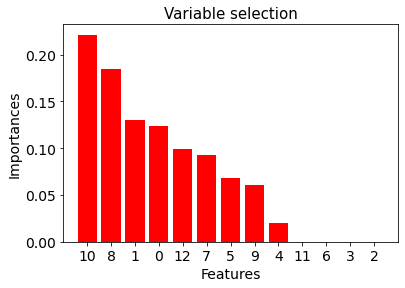

In [ ]:
feature_selection(features, target , model = DecisionTreeRegressor()) #sirve para ver cual variable tiene más correlación
# con la salida

In [ ]:
features.columns

Index(['CURRENT', 'FREQUENCY', 'PRESS_DESC', 'PRESS_INT', 'TEMP_INT',
       'TEMP_MOT', 'VIBRATION', 'GOR(MSFC/BPPD)', 'GLR(SCF/BFPD)', 'BSW',
       'API', 'PROF_INTAKE', 'PSI_CAB'],
      dtype='object')

## 2.4 Eliminación de variables sin peso 

In [ ]:
del train['VIBRATION']
del train['PSI_CAB']
del train['PRESS_INT']

del test['VIBRATION']
del test['PSI_CAB']
del test['PRESS_INT']

In [ ]:
train.sample(5)

WELL_ID                DATE  ...     PUMP  WellFailure
7689447  DEEPWATER-BOYHWX 2020-11-10 07:13:03  ...  ESP-905          NaN
3735775  DEEPWATER-HOQZS1 2020-09-26 00:12:03  ...  ESP-588          NaN
3326267  DEEPWATER-EKA0CA 2020-08-09 17:56:02  ...  ESP-555          NaN
6760755  DEEPWATER-VVBMZ0 2021-04-28 21:13:09  ...  ESP-100          NaN
6551380  DEEPWATER-ISTQBO 2020-10-24 07:46:02  ...  ESP-588          NaN

[5 rows x 14 columns]

In [ ]:
test.sample(5)

WELL_ID                DATE  ...     PUMP  WellFailure
715529  DEEPWATER-EHFSV4 2021-01-19 09:45:18  ...  ESP-480          NaN
153596  DEEPWATER-O4AWBU 2020-11-06 19:22:58  ...  ESP-154          NaN
220335  DEEPWATER-HTRCRO 2020-10-19 18:37:58  ...  ESP-411          NaN
385428  DEEPWATER-XWF4WL 2021-05-01 23:29:04  ...  ESP-588          NaN
381721  DEEPWATER-XWF4WL 2021-04-29 09:35:12  ...  ESP-588          NaN

[5 rows x 14 columns]

# 3. Construcción del modelo 

## 3.1 Balanceo de data

In [ ]:
def shuffle_df(df, random_seed=42):
    return df.sample(frac=1, random_state=random_seed, replace=False)

def oversample(df, y_col, n=None, random_state=42):
    """Sample an equal amount from each class, with replacement"""
    gs = [g for _, g in df.groupby(y_col)]
    if n is None:
        n = max(len(g) for g in gs)

    # sample equal number of each group
    gs = [g.sample(n, random_state=random_state, replace=True) for g in gs]
    # concat, and shuffle
    df = pd.concat(gs, 0)
    df = shuffle_df(df)
    return df

## 3.2 Modelo Deep Learning 

Para aplicar un aprendizaje más avanzado se ha optado por una red neuronal aplicado a los eventos disruptivos.

In [ ]:
data_input = oversample(train, "WellFailure", n=1000)

In [ ]:
data_input['WellFailure'].replace(('yes','Manual off'),(0,1),inplace=True)

In [ ]:
data_input.head()

WELL_ID                DATE  ...     PUMP  WellFailure
5785805  DEEPWATER-M24OXR 2019-09-30 00:00:00  ...  ESP-044            0
2050730  DEEPWATER-MU3BOW 2019-10-15 00:00:00  ...  ESP-004            1
2436319  DEEPWATER-A5W4QG 2020-12-07 00:01:43  ...  ESP-100            0
2824147  DEEPWATER-453GJ0 2020-04-03 00:00:00  ...  ESP-815            1
4373093  DEEPWATER-UY0V1O 2020-08-07 00:00:31  ...  ESP-100            0

[5 rows x 14 columns]

In [ ]:
train_labels=data_input['WellFailure']

In [ ]:
data_input.columns

Index(['WELL_ID', 'DATE', 'CURRENT', 'FREQUENCY', 'PRESS_DESC', 'TEMP_INT',
       'TEMP_MOT', 'GOR(MSFC/BPPD)', 'GLR(SCF/BFPD)', 'BSW', 'API',
       'PROF_INTAKE', 'PUMP', 'WellFailure'],
      dtype='object')

In [ ]:
columns_to_extract=['CURRENT', 'FREQUENCY', 'PRESS_DESC', 'TEMP_INT',
       'TEMP_MOT', 'GOR(MSFC/BPPD)', 'GLR(SCF/BFPD)', 'BSW', 'API',
       'PROF_INTAKE']

In [ ]:
train_features = data_input[columns_to_extract]

In [ ]:
test_features = test[columns_to_extract]

## 3.3 Convolutional Neuronal Network (CNN)

Modelo adecuado de aprendizaje profundo del canal Youtube full scan
https://youtu.be/NERPPvoj3Go

In [ ]:
train_features.shape

(2000, 10)

In [ ]:
import tensorflow as tf

In [ ]:
model =tf.keras.Sequential([
    tf.keras.Input((None,10,)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 128)         1408      
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          8256      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.binary_crossentropy,
             metrics=['accuracy'])

In [ ]:
history=model.fit(train_features,train_labels,validation_split=0.30,epochs=100)

Epoch 1/100
44/44 [==============================] - 1s 7ms/step - loss: 180.1792 - accuracy: 0.5186 - val_loss: 67.5383 - val_accuracy: 0.5033
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 81.3024 - accuracy: 0.5229 - val_loss: 39.8158 - val_accuracy: 0.5100
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 65.4798 - accuracy: 0.5229 - val_loss: 16.8123 - val_accuracy: 0.4967
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 46.0105 - accuracy: 0.5250 - val_loss: 32.7865 - val_accuracy: 0.5100
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 39.0364 - accuracy: 0.5279 - val_loss: 7.6374 - val_accuracy: 0.6100
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 29.6643 - accuracy: 0.5464 - val_loss: 8.9354 - val_accuracy: 0.6017
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 31.6157 - accuracy: 0.5421 - val_loss: 10.6072 - val_accuracy: 0.5883


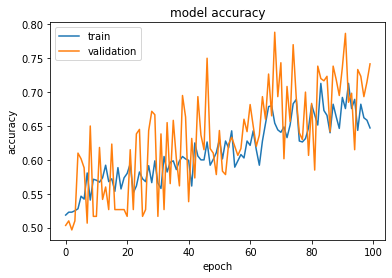

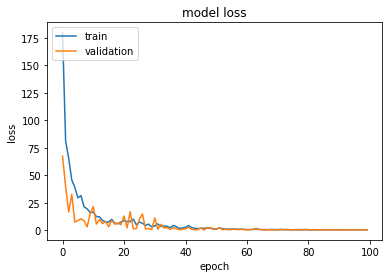

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

# 4 Predicciones

In [ ]:
%%time
predictions = model.predict(test_features)

CPU times: user 21.1 s, sys: 2.13 s, total: 23.2 s
Wall time: 20.6 s


In [ ]:
print(predictions)

[[0.7777955 ]
 [0.77900815]
 [0.7855922 ]
 ...
 [0.5400621 ]
 [0.5400621 ]
 [0.5400621 ]]


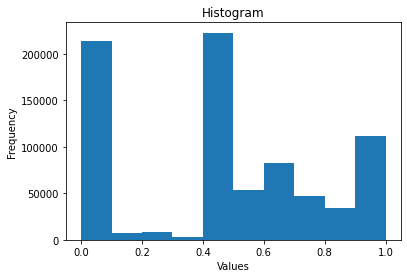

In [ ]:
n, bins, patches=plt.hist(predictions)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

In [ ]:
out=predictions.round().astype(int)

In [ ]:
test['WellFailure'] = out
# test = test.reset_index()
test

WELL_ID                DATE  ...     PUMP  WellFailure
0       DEEPWATER-O4AWBU 2019-02-25 00:00:00  ...  ESP-154            1
1       DEEPWATER-O4AWBU 2019-02-26 00:00:00  ...  ESP-154            1
2       DEEPWATER-O4AWBU 2019-02-27 00:00:00  ...  ESP-154            1
3       DEEPWATER-O4AWBU 2019-02-28 00:00:00  ...  ESP-154            1
4       DEEPWATER-O4AWBU 2019-03-01 00:00:00  ...  ESP-154            1
...                  ...                 ...  ...      ...          ...
786086  DEEPWATER-EHFSV4 2021-05-25 09:24:35  ...  ESP-588            1
786087  DEEPWATER-EHFSV4 2021-05-25 09:25:58  ...  ESP-588            1
786088  DEEPWATER-EHFSV4 2021-05-25 09:26:21  ...  ESP-588            1
786089  DEEPWATER-EHFSV4 2021-05-25 09:27:31  ...  ESP-588            1
786090  DEEPWATER-EHFSV4 2021-05-25 09:28:53  ...  ESP-588            1

[786091 rows x 14 columns]

# 4.1 Eventos Plots

In [ ]:
test['WELL_ID'].unique()

array(['DEEPWATER-O4AWBU', 'DEEPWATER-HTRCRO', 'DEEPWATER-3XFTSJ',
       'DEEPWATER-QVFBDM', 'DEEPWATER-XWF4WL', 'DEEPWATER-LIS23E',
       'DEEPWATER-OUFAML', 'DEEPWATER-M3XG2L', 'DEEPWATER-2ZLRT1',
       'DEEPWATER-EHFSV4'], dtype=object)

In [ ]:
test_well = test[test['WELL_ID']=='DEEPWATER-O4AWBU']

In [ ]:
test_well

WELL_ID                DATE  ...     PUMP  WellFailure
0       DEEPWATER-O4AWBU 2019-02-25 00:00:00  ...  ESP-154            1
1       DEEPWATER-O4AWBU 2019-02-26 00:00:00  ...  ESP-154            1
2       DEEPWATER-O4AWBU 2019-02-27 00:00:00  ...  ESP-154            1
3       DEEPWATER-O4AWBU 2019-02-28 00:00:00  ...  ESP-154            1
4       DEEPWATER-O4AWBU 2019-03-01 00:00:00  ...  ESP-154            1
...                  ...                 ...  ...      ...          ...
165648  DEEPWATER-O4AWBU 2021-05-25 07:59:19  ...  ESP-411            1
165649  DEEPWATER-O4AWBU 2021-05-25 08:19:09  ...  ESP-411            1
165650  DEEPWATER-O4AWBU 2021-05-25 08:38:59  ...  ESP-411            1
165651  DEEPWATER-O4AWBU 2021-05-25 08:58:50  ...  ESP-411            1
165652  DEEPWATER-O4AWBU 2021-05-25 09:19:50  ...  ESP-411            1

[165653 rows x 14 columns]

In [ ]:
test_well.columns

Index(['WELL_ID', 'DATE', 'CURRENT', 'FREQUENCY', 'PRESS_DESC', 'TEMP_INT',
       'TEMP_MOT', 'GOR(MSFC/BPPD)', 'GLR(SCF/BFPD)', 'BSW', 'API',
       'PROF_INTAKE', 'PUMP', 'WellFailure'],
      dtype='object')

In [ ]:
test_well['PUMP'].unique()

array(['ESP-154', 'ESP-411'], dtype=object)

In [ ]:
import plotly.graph_objects as go

In [ ]:
figura = go.Figure()
figura.add_trace(go.Scatter(
    x=test_well['DATE'],
    y=test_well['PUMP'],
    name="PUMP"
))

figura.add_trace(go.Scatter(
    x=test_well['DATE'],
    y=test_well['PRESS_DESC'],
    name="PRESS_DESC",
    yaxis="y2"
))

figura.add_trace(go.Scatter(
    x=test_well['DATE'],
    y=test_well['FREQUENCY'],
    name="FREQUENCY",
    yaxis="y3"
))

figura.add_trace(go.Scatter(
    x=test_well['DATE'],
    y=test_well['GOR(MSFC/BPPD)'],
    name="GOR(MSFC/BPPD)",
    yaxis="y4"
))



figura.add_trace(go.Scatter(
    x=test_well['DATE'],
    y=test_well['CURRENT'],
    name="CURRENT",
    yaxis="y5"
))



figura.add_trace(go.Scatter(
    x=test_well['DATE'],
    y=test_well['WellFailure'],
    name="WellFailure",
    yaxis="y6"
))

# Create axis objects
figura.update_layout(
    xaxis=dict(
        domain=[0.15,0.78]
    ),
    yaxis=dict(
        title="PUMP",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title="PRESS_DESC",
        titlefont=dict(
            color="#FF0000"
        ),
        tickfont=dict(
            color="#FF0000"
        ),
        anchor="free",
        overlaying="y",
        side="left",
        position=0.07
    ),
    yaxis3=dict(
        title="FREQUENCY",
        titlefont=dict(
            color="#00ff00"
        ),
        tickfont=dict(
            color="#00ff00"
        ),
        anchor="x",
        overlaying="y",
        side="right"
    ),
    yaxis4=dict(
        title="GOR(MSFC/BPPD)",
        titlefont=dict(
            color="#8c004b"
        ),
        tickfont=dict(
            color="#8c004b"
        ),
        anchor="free",
        overlaying="y",
        side="right",
        position=0.85
    ),
    
     yaxis5=dict(
        title="CURRENT",
        titlefont=dict(
            color="#ff8000"
        ),
        tickfont=dict(
            color="#ff8000"
        ),
        anchor="free",
        overlaying="y",
        side="right",
        position=0.93
    ),
     yaxis6=dict(
        title="WellFailure",
        titlefont=dict(
            color="#00aae4"
        ),
        tickfont=dict(
            color="#00aae4"
        ),
        anchor="free",
        overlaying="y",
        side="right",
        position=1.00
    )
)

figura.update_layout(
    title_text="Eventos Resultantes",
    width=1200,
)

figura.show()

In [ ]:
test['WellFailure'].replace((0,1),('yes','Manual off'),inplace=True)

In [ ]:
test['WellFailure'].value_counts()

yes           455763
Manual off    330328
Name: WellFailure, dtype: int64

In [ ]:
test_final = test.copy()

## Resultado de la predicción

In [ ]:
test_pozos = ['DEEPWATER-O4AWBU', 'DEEPWATER-HTRCRO', 'DEEPWATER-3XFTSJ',
       'DEEPWATER-QVFBDM', 'DEEPWATER-XWF4WL', 'DEEPWATER-LIS23E',
       'DEEPWATER-OUFAML', 'DEEPWATER-M3XG2L', 'DEEPWATER-2ZLRT1',
       'DEEPWATER-EHFSV4']

In [ ]:
result = []
for i in test_pozos:
    df = test_final[test_final['WELL_ID']==i][['WELL_ID','DATE','WellFailure']].reset_index().drop('index',axis=1)
    result.append(df.sample(1))

result = np.vstack(result)
result = pd.DataFrame(result,columns=['WELL_ID','DATE','WellFailure'])
result

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2020-11-01 08:50:01         yes
1  DEEPWATER-HTRCRO 2020-09-29 07:32:40         yes
2  DEEPWATER-3XFTSJ 2020-11-04 21:24:47  Manual off
3  DEEPWATER-QVFBDM 2021-03-23 14:58:41         yes
4  DEEPWATER-XWF4WL 2021-04-30 21:55:21  Manual off
5  DEEPWATER-LIS23E 2020-03-08 06:13:08  Manual off
6  DEEPWATER-OUFAML 2020-10-16 08:59:01  Manual off
7  DEEPWATER-M3XG2L 2020-11-07 14:27:25  Manual off
8  DEEPWATER-2ZLRT1 2021-05-25 02:02:16  Manual off
9  DEEPWATER-EHFSV4 2021-03-15 12:58:06         yes

#<b> Blind Scoring

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yqJnu5Liti62EAWoem5wee472biMrTEf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yqJnu5Liti62EAWoem5wee472biMrTEf" -O blind_result.csv && rm -rf /tmp/cookies.txt

In [ ]:
result = result.drop(1).reset_index().drop('index',1)
result

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2020-11-01 08:50:01         yes
1  DEEPWATER-3XFTSJ 2020-11-04 21:24:47  Manual off
2  DEEPWATER-QVFBDM 2021-03-23 14:58:41         yes
3  DEEPWATER-XWF4WL 2021-04-30 21:55:21  Manual off
4  DEEPWATER-LIS23E 2020-03-08 06:13:08  Manual off
5  DEEPWATER-OUFAML 2020-10-16 08:59:01  Manual off
6  DEEPWATER-M3XG2L 2020-11-07 14:27:25  Manual off
7  DEEPWATER-2ZLRT1 2021-05-25 02:02:16  Manual off
8  DEEPWATER-EHFSV4 2021-03-15 12:58:06         yes

In [ ]:
blind_result = pd.read_csv('blind_result.csv',parse_dates=[1])
blind_result 

WELL_ID                DATE WellFailure
0  DEEPWATER-O4AWBU 2020-08-23 00:00:03         yes
1  DEEPWATER-3XFTSJ 2020-12-15 00:19:05         yes
2  DEEPWATER-QVFBDM 2020-06-07 00:04:37         yes
3  DEEPWATER-XWF4WL 2021-04-12 00:18:57         yes
4  DEEPWATER-LIS23E 2020-04-02 00:00:00         yes
5  DEEPWATER-OUFAML 2021-04-01 00:01:30         yes
6  DEEPWATER-M3XG2L 2020-02-28 00:00:00         yes
7  DEEPWATER-2ZLRT1 2020-08-13 00:19:02         yes
8  DEEPWATER-EHFSV4 2021-05-01 00:01:51         yes

In [ ]:
truth = blind_result.copy()
pred = result.copy()

if pred.isnull().sum().sum() == 0:

####################################################################################

    if (truth['WELL_ID'] == pred['WELL_ID']).all() and len(np.union1d(truth.keys(),pred.keys()))==3:
        score = pd.merge(truth,pred,on=['WELL_ID'],suffixes=('_true','_pred'),how='left')
        
        ############################ GRADE DATE PREDICTION #####################################
        date_scores = []

        for i in score.index:
            
            timedelta = (pd.Timestamp(score.iloc[i,1]) - pd.Timestamp(score.iloc[i,3])).days
            if timedelta < 0:
                timedelta = (pd.Timestamp(score.iloc[i,3]) - pd.Timestamp(score.iloc[i,1])).days
                
            if timedelta == 0:
                date_scores.append(1)        
            elif timedelta == 1:
                date_scores.append(0.9) 
            elif timedelta == 2:
                date_scores.append(0.8)  
            elif timedelta == 3:
                date_scores.append(0.7)
            elif timedelta == 4:
                date_scores.append(0.6)
            elif timedelta == 5:
                date_scores.append(0.5)
            elif timedelta == 6:
                date_scores.append(0.4)   
            elif timedelta == 7:
                date_scores.append(0.3)                                                                
            elif timedelta == 8:
                date_scores.append(0.2)   
            elif timedelta <30:
                date_scores.append(-1)         
            else:
                date_scores.append(-3)

        date_score = np.sum(date_scores)/len(truth)

        ################################### GRADE ACCURACY PREDICTION ##########################
        failure_score = accuracy_score(score['WellFailure_true'].values,score['WellFailure_pred'].values)
        
        ##################################### FINAL SCORE ######################################
        
        final_score = round(date_score*failure_score,3)

    else:
        final_score = -999

final_score

-0.852

<h1><b> Final Score: 
<h2><b> -0.852
<h3> Tested by Felix Gallo
<h3> E-Challenge Team
<h3><B> SPE Ecuador Section

In [ ]:
# Write the prediction to a zip file
result.to_csv('predictions.csv',index=False)
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")